# Fully Funtioning Backend Demo

This notebook is designed to show how the DSEM pipeline works. It's fully funtioning, using SEM and RL NAS. Please fasten your seat belt and enjoy the journey.

In [1]:
import numpy as np
import pandas as pd
import autogluon as ag
import rpy2.rinterface_lib as rlib
import rpy2.robjects as ro
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '..')
from SEM import SemModel

## 1. Data

In this demo, we use dataset _PoliticalDemocracy_ from Bollen's book on structural equation modeling published in 1989. We load this dataset in R and convert it to Python Dataframe for further usage.

In [2]:
# Load this dataset in R.
ro.packages.importr('lavaan')
rData = ro.r('PoliticalDemocracy')

# Convert it to Python Dataframe.
with ro.conversion.localconverter(ro.default_converter + ro.pandas2ri.converter):
    data = ro.conversion.rpy2py(rData)
data.describe()

,y1,y2,y3,y4,y5,y6,y7,y8,x1,x2,x3
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,5.464667,4.256443,6.563110,4.452533,5.136252,2.978074,6.196264,4.043390,5.054384,4.792195,3.557690
std,2.622702,3.947128,3.280891,3.349467,2.612602,3.372733,3.286240,3.245593,0.732904,1.510664,1.405711
min,1.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.784190,1.386294,1.001674
25%,2.900000,0.000000,3.766667,1.581500,3.691701,0.000000,3.477661,1.300916,4.477337,3.663233,2.300181
50%,5.400000,3.333333,6.666666,3.333333,5.000000,2.233333,6.666666,3.333333,5.075174,4.962845,3.568079
75%,7.500000,8.283332,9.999998,6.666666,7.500000,4.206853,9.999998,6.666666,5.515424,5.830362,4.522988
max,10.000000,9.999998,10.000000,10.000000,10.000000,9.999998,9.999998,10.000000,6.736967,7.872074,6.424591


## 2. Conventional SEM

After loading this dataset, let's play with the conventional SEM. It is a truth universally acknowledged, that SEM is rather confirmative than explorative. So the very only way to play with the conventional SEM is to run SEM on a manually proposed model.

Therefore, we use the model from lavaan (a package in R) official tutorial as an example.

In [3]:
# Describe the model
model = '''
  # measurement model
    ind60 =~ x1 + x2 + x3
    dem60 =~ y1 + y2 + y3 + y4
    dem65 =~ y5 + y6 + y7 + y8
  # regressions
    dem60 ~ ind60
    dem65 ~ ind60 + dem60
'''

# Create the model and fit the data.
sem = SemModel()
buildRes = sem.build_sem_model(model)
assert buildRes
fitRes = sem.fit_sem_model(data)
assert fitRes['is_fitted']

# Evaluate the model fitted.
measureRes = sem.evaluate_sem_model()
print('AGFI: %f \nRMSEA: %f' % (
    measureRes['agfi'], 
    measureRes['rmsea']))

AGFI: 0.765110 
RMSEA: 0.101150


## 3. Deep SEM

Now let's try to apply RL NAS technology to SEM. In this section, we define the search space first, and then the search strategy, finally let's combine everything together.

Firstly, let's start with search space.

### 3.1. Search Space

In [4]:
facNames = ['factor1', 'factor2', 'factor3']  # Use the same factor number as the model propsoed above.
facNum = len(facNames)
varNames = data.columns
varNum = len(varNames)

# Define the search space.
searchSpace = {var: ag.space.Categorical(*facNames) 
               for var in varNames}  # Define search space for measurement model
for i in range(facNum):  # Define search space for regressions model
    for j in range(i):
        searchSpace[str((facNames[i], facNames[j]))] = ag.space.Categorical(*list(range(3)))

errorMsg = []

def logErrorMsg(s) :
    errorMsg.append(s)

rlib.callbacks.consolewrite_warnerror = logErrorMsg

def evaluateSolution(model):
    try:
        sem = SemModel()

        buildRes = sem.build_sem_model(model)
        if not buildRes:
            return 0

        fitRes = sem.fit_sem_model(data)
        if not fitRes['is_fitted']:
            return 0

        measureRes = sem.evaluate_sem_model()
        if not measureRes['is_evaluated']:
            return 0

        AGFI = measureRes['agfi']
        RMSEA = measureRes['rmsea']
        index = AGFI - RMSEA * 10
        sigmoidIndex = 1/(1 + np.exp(-index)) 
        return sigmoidIndex
    except:
        return 0

def dict2des(dataDict, seperator):
    dataDes = ''
    for parent in dataDict.keys():
        if not dataDict[parent]:
            continue;
        
        relaDes = '' 
        for son in dataDict[parent]:
            if not relaDes:
                relaDes += son
            else:
                relaDes += ' + ' + son
                
        dataDes += parent + ' ' + seperator + ' ' + relaDes + '\n'
       
    return dataDes
    
@ag.args(**searchSpace)
def rl_simulation(args, reporter):
    measurementDict = {fac: [] for fac in facNames}
    regressionsDict = {fac: [] for fac in facNames} 
        
    for var, choice in args.items():
        if var == 'task_id': 
            continue
        elif var[0] != '(':  # measurement
            measurementDict[choice].append(var)
        else:  # regressions
            varTuple = eval(var)
            if choice == 1:
                regressionsDict[varTuple[0]].append(varTuple[1])
            elif choice == 2:
                regressionsDict[varTuple[1]].append(varTuple[0])
    
    # Prior knowledge from SEM.
    for fac, ind in measurementDict.items():
        if (len(ind) < 2):
            reporter(reward=0)
            return
    
    modelDes = dict2des(measurementDict, '=~') + \
               dict2des(regressionsDict, '~')
    
    reward = evaluateSolution(modelDes)
    
    reporter(reward=reward)
    

### 3.2. Search Strategy

In [5]:
# Running the following code might crash Python.
# This problem is caused by the multiprocessing of the RL algorithm and lavaan in R.
# But the numeric part has been take care of, so the result is not currupted.
rl_scheduler = ag.scheduler.RLScheduler(rl_simulation,
                                        resource={'num_cpus': 1, 'num_gpus': 0},
                                        num_trials=200,
                                        reward_attr='reward',
                                        controller_batch_size=4,
                                        controller_lr=5e-3,)

rl_scheduler.run()
rl_scheduler.join_jobs()
    
print('Best config: {}, best reward: {}'.format(rl_scheduler.get_best_config(), rl_scheduler.get_best_reward()))

scheduler_options: Key 'resume': Imputing default value False
scheduler_options: Key 'checkpoint': Imputing default value ./exp/checkpoint.ag
scheduler_options: Key 'ema_baseline_decay': Imputing default value 0.95
scheduler_options: Key 'controller_resource': Imputing default value {'num_cpus': 0, 'num_gpus': 0}
scheduler_options: Key 'sync': Imputing default value True

scheduler_options: Key 'time_attr': Imputing default value epoch
scheduler_options: Key 'visualizer': Imputing default value none
scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Reserved DistributedResource(
	Node = Remote REMOTE_ID: 0, 
	<Remote: 'inproc://192.168.248.128/65880/1' processes=1 threads=4, memory=8.16 GB>
	nCPUs = 0) in Remote REMOTE_ID: 0, 
	<Remote: 'inproc://192.168.248.128/65880/1' processes=1 threads=4, memory=8.16 GB>
Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks 

Error in evaluate_sem_model function.
Error in evaluate_sem_model function.

Best config: {'y1▁choice': 0, 'y2▁choice': 1, 'y3▁choice': 1, 'y4▁choice': 1, 'y5▁choice': 1, 'y6▁choice': 0, 'y7▁choice': 0, 'y8▁choice': 1, 'x1▁choice': 2, 'x2▁choice': 2, 'x3▁choice': 2, "('factor2', 'factor1')▁choice": 1, "('factor3', 'factor1')▁choice": 2, "('factor3', 'factor2')▁choice": 2}, best reward: 0.4451052196984714


### 3.3. Learning Curve

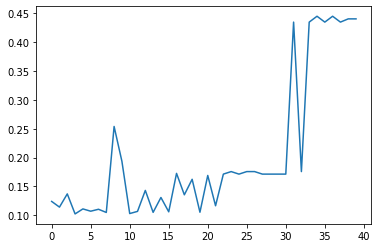

In [6]:
curveRL = [v[0]['reward'] for v in rl_scheduler.training_history.values()]
curveSmooth = [np.max(curveRL[i:i+5]) for i in range(0, len(curveRL), 5)]

plt.plot(range(len(curveSmooth)), curveSmooth)

## 4. Comparison

Now let's compare those conventional SEM and DSEM. First let's started with conventional SEM.

In [7]:
model = '''
  # measurement model
    ind60 =~ x1 + x2 + x3
    dem60 =~ y1 + y2 + y3 + y4
    dem65 =~ y5 + y6 + y7 + y8
  # regressions
    dem60 ~ ind60
    dem65 ~ ind60 + dem60
'''

evaluateSolution(model)

0.43871110839477384

Now let's move to DSEM.

In [8]:
args = rl_scheduler.get_best_config()

measurementDict = {fac: [] for fac in facNames}
regressionsDict = {fac: [] for fac in facNames} 
        
for var, choice in args.items():
    var = var.split('▁')[0]
    if var[0] != '(':  # measurement
        measurementDict[facNames[choice]].append(var)
    else:  # regressions
        varTuple = eval(var)
        if choice == 1:
            regressionsDict[varTuple[0]].append(varTuple[1])
        elif choice == 2:
            regressionsDict[varTuple[1]].append(varTuple[0])

modelDes = dict2des(measurementDict, '=~') + \
           dict2des(regressionsDict, '~')

print('The best model looks like:\n' + modelDes)
    
evaluateSolution(modelDes)

The best model looks like:
factor1 =~ y1 + y6 + y7
factor2 =~ y2 + y3 + y4 + y5 + y8
factor3 =~ x1 + x2 + x3
factor1 ~ factor3
factor2 ~ factor1 + factor3



0.4451052196984714